## In Depth PCA on US Arrests Dataset

In [ ]:
"""
US Arrests Dataset: In-Depth PCA and Clustering Analysis

This Jupyter notebook performs a comprehensive analysis of the US Arrests
dataset, focusing on understanding the underlying patterns in US crime data
through Principal Component Analysis (PCA) and clustering techniques.
The analysis pipeline is structured as follows:

1. **Introduction**: An overview of the objectives and the analytical approach
undertaken in the notebook.

2. **Preprocessing**:
   - Load and View Data: Initial examination of the dataset, including renaming
     columns for clarity.
   - Get Data Information: Assessment of data completeness and preparation for
     analysis.
   - Separate Data: Segregation of features for further analysis.

3. **Data Distribution Visualizations**:
   - Correlation Matrix: Exploration of relationships between variables.
   - Pairplot: Visualization of pairwise relationships in the dataset.
   - State vs Features Bar Graphs: Comparative analysis of crime statistics
     across states.

4. **PCA**:
   - Analysis on Non-Standardised Data: Initial PCA to understand the variance
     explained by principal components.
   - Biplot Creation: Visualization of the PCA results to interpret feature
     contributions and state distributions.
   - Analysis on Standardised Data: PCA on scaled data to normalize feature
     scales and better understand feature contributions to principal components.

5. **Clustering**:
   - Application of Hierarchical Clustering and KMeans Clustering to the
     dimensionality-reduced data.


6. **Discussion**:
   - Evaluation of clusters formed and discussion on the characteristics of
     states grouped together.
"""

### Introduction

This notebook carries out an in depth Principal Component Analysis (PCA) on the US Arrests dataset. After preprocessing, the distribution of the data is viewed through a correlation matrix and a pairplot. The PCA is then done for both the non-standardised and standardised data. After analysis of the cumulative explained variance, the dimensionality of the data is reduced. From the reduced data, two clustering methods are applied: heirachical clustering and KMeans clustering. The various clusters are evaluated and discuassions are made.

### Preprocessing

In [1164]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

rseed = 42

#### Load and View Data

In [1165]:
data = pd.read_csv('UsArrests.csv')
data.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.200,236,58,21.200
1,Alaska,10.000,263,48,44.500
2,Arizona,8.100,294,80,31.000
3,Arkansas,8.800,190,50,19.500
4,California,9.000,276,91,40.600


Rename 'City' column to 'State'

In [1166]:
# Rename the 'City' column to 'State'
data.rename(columns={'City': 'State'}, inplace=True)

#### Get Data Information

In [1167]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


,Murder,Assault,UrbanPop,Rape
count,50.000,50.000,50.000,50.000
mean,7.788,170.760,65.540,21.232
std,4.356,83.338,14.475,9.366
min,0.800,45.000,32.000,7.300
25%,4.075,109.000,54.500,15.075
50%,7.250,159.000,66.000,20.100
75%,11.250,249.000,77.750,26.175
max,17.400,337.000,91.000,46.000


There are no missing values in this dataset and we may continue with evaluating the data.

#### Separate Data

In [1168]:
X = data.drop(['State'], axis=1)
states = data['State']

### Data Distribution Visualisations

#### Correlation Matrix

<ipython-input-1169-fbf9abcf00de>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


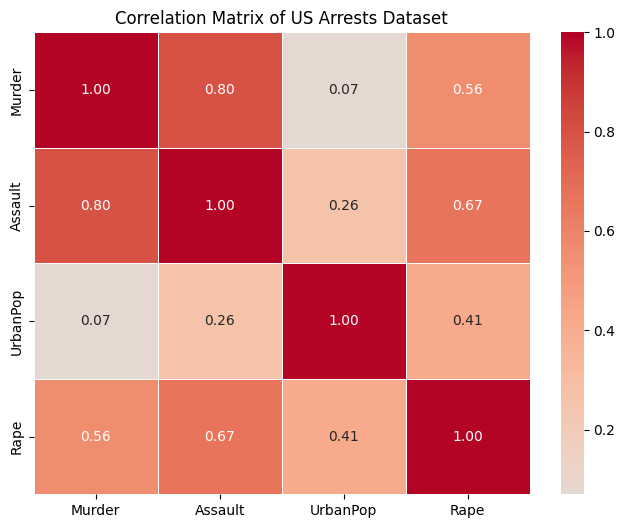

In [1169]:
# Calculating the correlation matrix
correlation_matrix = data.corr()
labels =correlation_matrix.columns

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, center=0)
plt.title('Correlation Matrix of US Arrests Dataset')
plt.show()

#### Pairplot

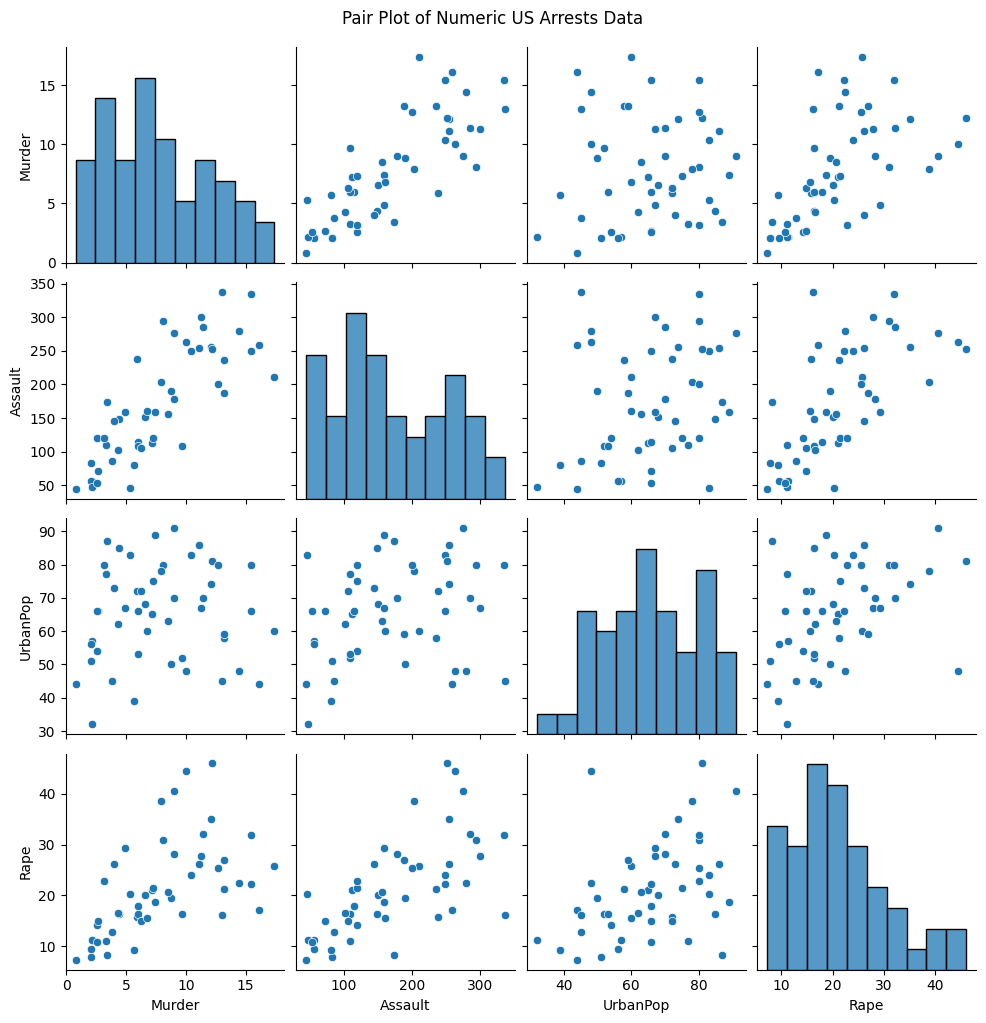

In [1170]:
sns.pairplot(data, diag_kws={'bins': 10})
plt.suptitle('Pair Plot of Numeric US Arrests Data', y=1.02)
plt.show()

From both the correlation matrix and the pairplot we can see that the strongest correlation is between assualt and murder. There is also a weaker positive correlation with rape and assualt followed by rape and murder. The urban population has a weak correlation with rape and appears to have no correlation with assualt or murder. The most common crime (with the largests values) is assault followed by rape and then murder.

#### State vs Features Bar Graphs

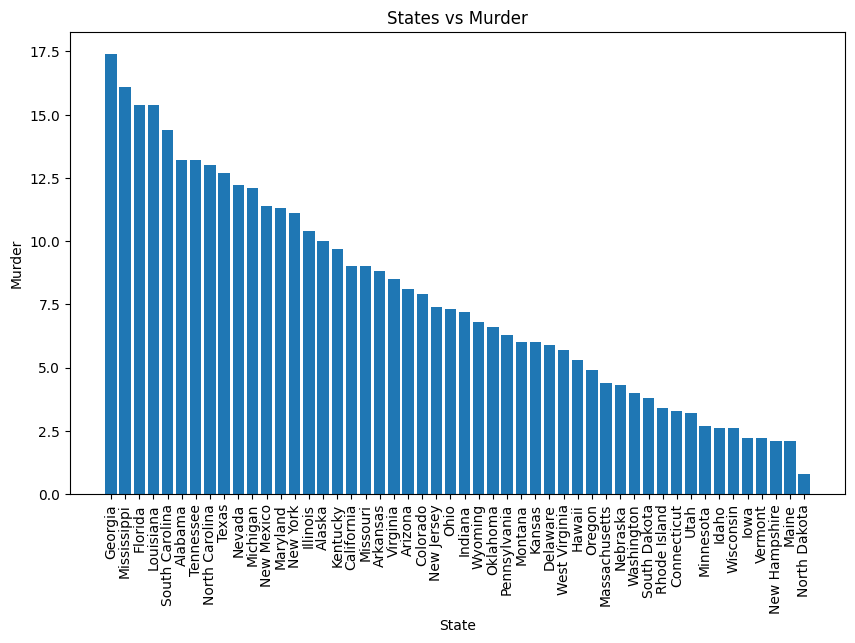

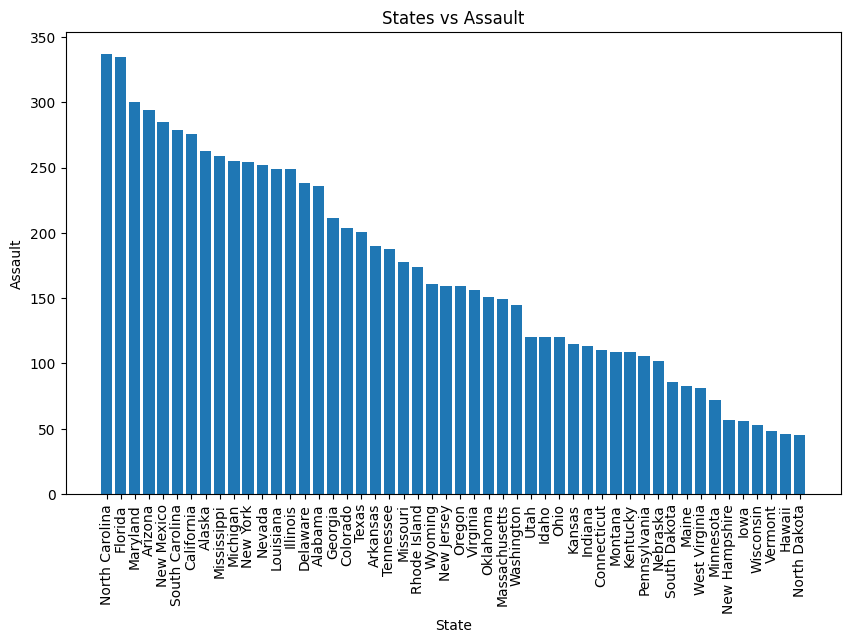

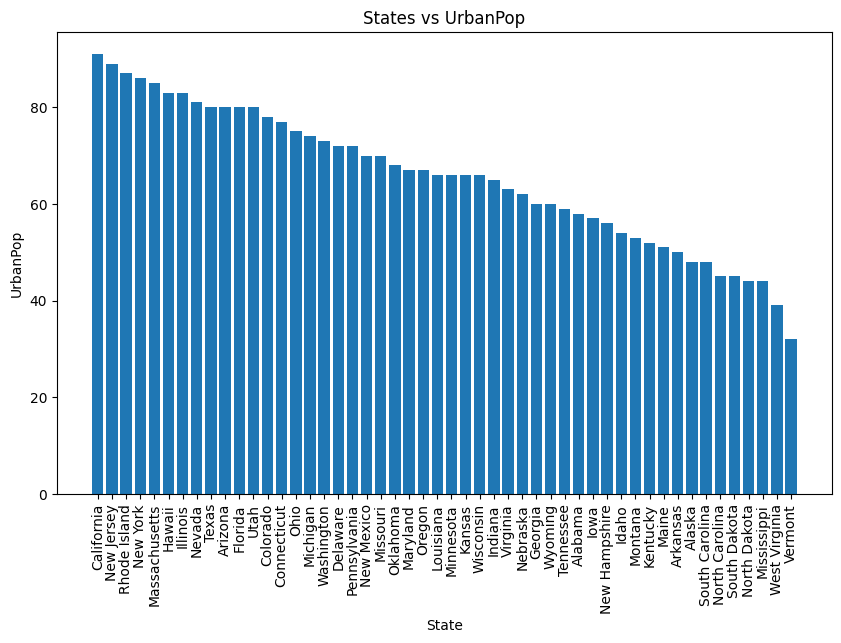

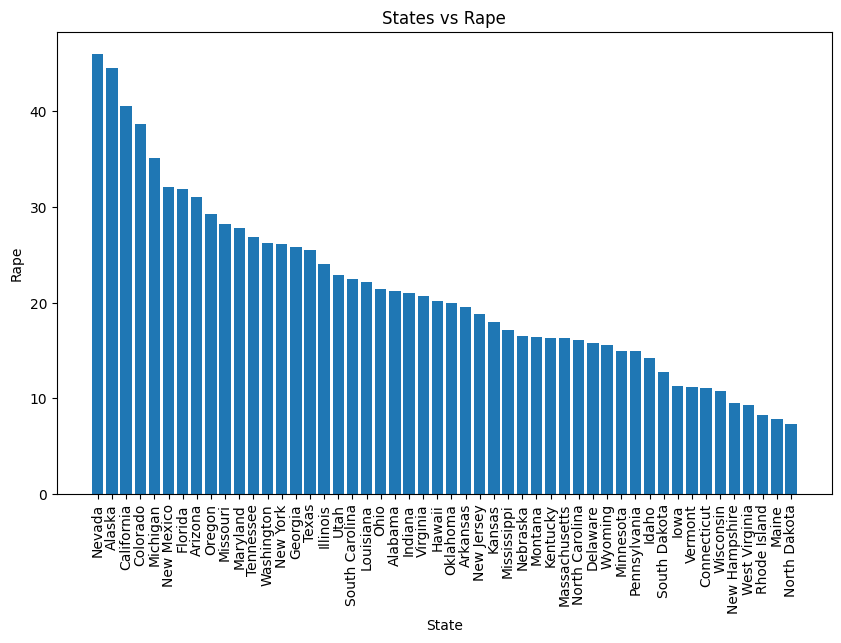

In [1171]:
# Create a list of crime variables and urban population
variables = X.columns.tolist()

# Sort DataFrame by each crime variable in descending order
for variable in variables:
    sorted_df = data.sort_values(by=variable, ascending=False)

    # Plot states vs crime variable
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_df['State'], sorted_df[variable])
    plt.title(f'States vs {variable}')
    plt.xlabel('State')
    plt.ylabel(variable)
    plt.xticks(rotation=90)
    plt.show()

These bar graphs can be used later on to compare clustering groups of the states.

### PCA

#### Non-Standardised Data

Get PCA on non-standardised data

In [1172]:
# Set the precision
np.set_printoptions(precision=2)
# Initialize the PCA model
pca = PCA()
# Fit the PCA model to the dataset
X_pca = pca.fit_transform(X)
# Convert to a DataFrame
pca_df = pd.DataFrame(X_pca)
pca_df.head()

,0,1,2,3
0,64.802,11.448,-2.495,2.408
1,92.827,17.983,20.127,-4.094
2,124.068,-8.830,-1.687,-4.354
3,18.340,16.704,0.210,-0.521
4,107.423,-22.520,6.746,-2.812


In [1173]:
def biplot(score,coeff,labels=None,points=None):
    """
    Create a biplot that displays a scatterplot of the scores on the first two
    principal components and vectors representing the coefficients for each
    variable in the data. The length of the vectors indicates the importance of
    the variable in the principal components.

    Parameters:
    - score : array-like
    - coeff : array-like
    - labels : list of str, optional (default=None)
    - points : list of str, optional (default=None)

    Returns:
    - A matplotlib figure containing the biplot with points representing the
      projected scores and vectors indicating the direction and magnitude of the
      variables on the principal components.
    """
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = states[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

# Adapted from example_plots.ipynb file provided by HyperionDev
# who adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

Create biplot of non-standardised data.

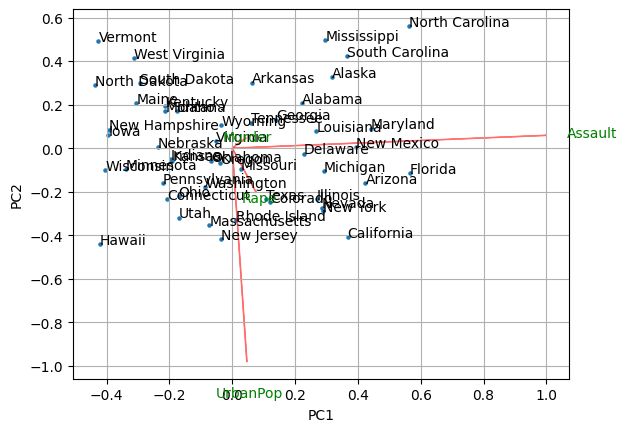

In [1174]:
# Create biplot of non-standardised data
biplot(X_pca[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(states))
plt.show()

From the biplot we can see that assualt contributes the most to PC1. It is difficult to see the contribution from the other features or how the states vary with respect to the other features. We thus need to scale the data.

View importance of features in each principal component.

In [1175]:
# Feature importance (adapted from example_plots.ipynb)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pc1 = abs( pca.components_[0] )
pc2 = abs( pca.components_[1] )
pc3 = abs( pca.components_[2] )
pc4 = abs( pca.components_[3] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df["PC3 Importance"] = pc3
feat_df["PC4 Importance"] = pc4
feat_df

,Features,PC1 Importance,PC2 Importance,PC3 Importance,PC4 Importance
0,Murder,0.042,0.045,0.080,0.995
1,Assault,0.995,0.059,0.068,0.039
2,UrbanPop,0.046,0.977,0.201,0.058
3,Rape,0.075,0.201,0.974,0.072


#### Standardised Data

In [1176]:
# Standardise numerical data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Get PCA on standardised data

In [1177]:
# Initialize the PCA model
pca_scaled = PCA()
# Fit the PCA model to the scaled data
X_scaled_pca = pca_scaled.fit_transform(X_scaled)
# Convert to a DataFrame
pca_df_scaled = pd.DataFrame(X_scaled_pca)
pca_df_scaled.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


Create biplot of standardised data.

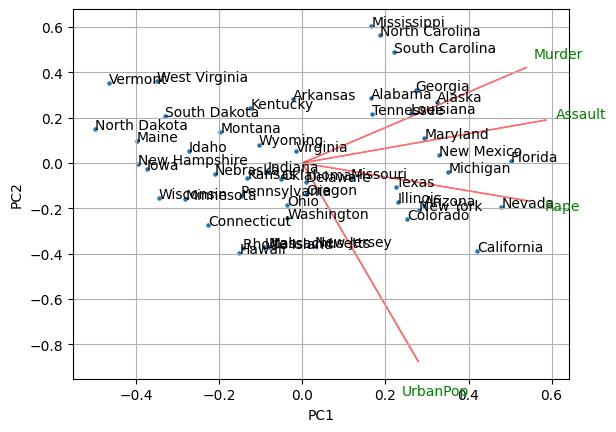

In [1178]:
# Create biplot of standardised data
biplot(X_scaled_pca[:,0:2],np.transpose(pca_scaled.components_[0:2, :]),list(labels))
plt.show()

From the biplot of the scaled data, states on the right side of the plot experience more crime than those on the left side.

View importance of features in each principal component.

In [1179]:
# Feature importance (adapted from example_plots.ipynb)
pc1 = abs( pca_scaled.components_[0] )
pc2 = abs( pca_scaled.components_[1] )
pc3 = abs( pca_scaled.components_[2] )
pc4 = abs( pca_scaled.components_[3] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df["PC3 Importance"] = pc3
feat_df["PC4 Importance"] = pc4
feat_df

,Features,PC1 Importance,PC2 Importance,PC3 Importance,PC4 Importance
0,Murder,0.536,0.418,0.341,0.649
1,Assault,0.583,0.188,0.268,0.743
2,UrbanPop,0.278,0.873,0.378,0.134
3,Rape,0.543,0.167,0.818,0.089


#### Dimension Reduction

Create a cumulatie explained variance plot and scree plot to determine the optimal number of components.

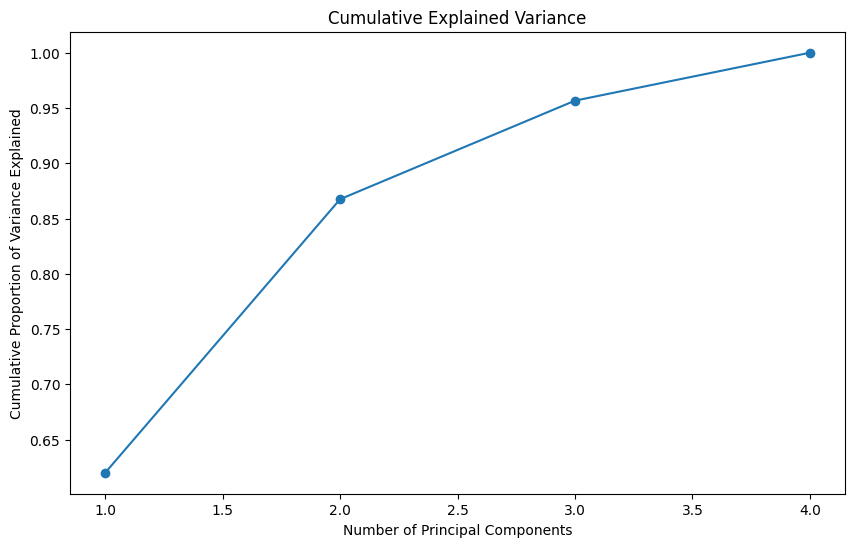

In [1180]:
# Cumulative explained variance plot
cumulative_variance = np.cumsum(pca_scaled.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.show()


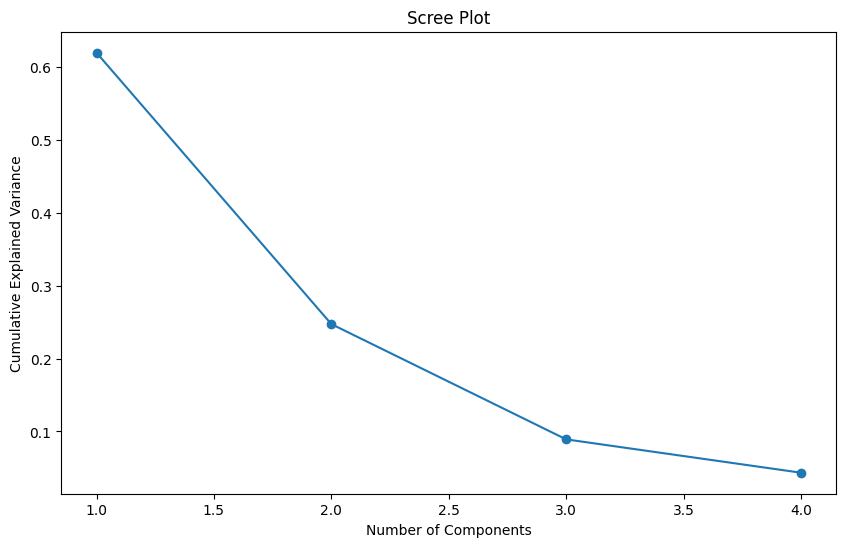

In [1181]:
# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca_scaled.explained_variance_ratio_) + 1), pca_scaled.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

The first 3 principal components together explain most of the variance (around 95%) and we can therefore use them to perform the cluster analysis. We thus reduce our dimensionality from 4 to 3.

Reduce the dimensionality.

In [1182]:
# Number of components
nr_comps = 3
# Initialize the PCA model with the number of components
pca_reduced = PCA(n_components=nr_comps)
# Fit the PCA model to the scaled data
X_reduced_pca = pca_reduced.fit_transform(X_scaled)
# Convert to a DataFrame
pca_df_reduced = pd.DataFrame(X_reduced_pca, columns = ['PC1', 'PC2', 'PC3'])
pca_df_reduced.head()

,PC1,PC2,PC3
0,0.986,1.133,-0.444
1,1.950,1.073,2.040
2,1.763,-0.746,0.055
3,-0.141,1.120,0.115
4,2.524,-1.543,0.599


In [1183]:
# Change index to state names
pca_df_reduced.index = states.tolist()
pca_df_reduced.head()

,PC1,PC2,PC3
Alabama,0.986,1.133,-0.444
Alaska,1.950,1.073,2.040
Arizona,1.763,-0.746,0.055
Arkansas,-0.141,1.120,0.115
California,2.524,-1.543,0.599


View 3D plot of principal components.

<ipython-input-1184-7a927bd58c0b>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], X_reduced_pca[:, 2], cmap='viridis', edgecolor='k', s=50)


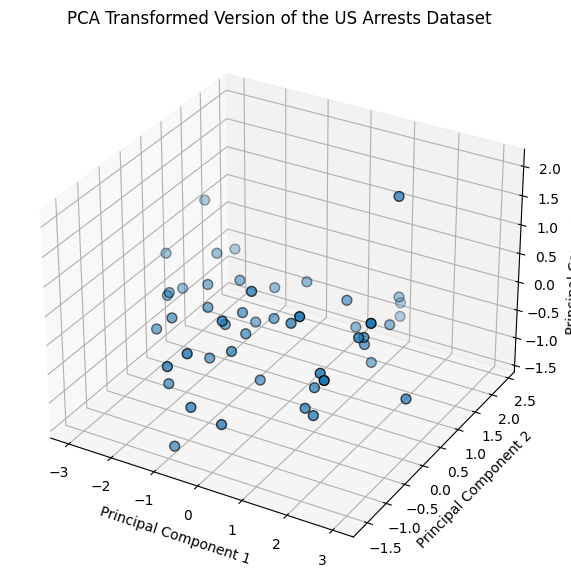

In [1184]:
# 3D plot of the transformed version of the data
# Reference: https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], X_reduced_pca[:, 2], cmap='viridis', edgecolor='k', s=50)
ax.set_title('PCA Transformed Version of the US Arrests Dataset')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

View correlations between principal components and original variables.

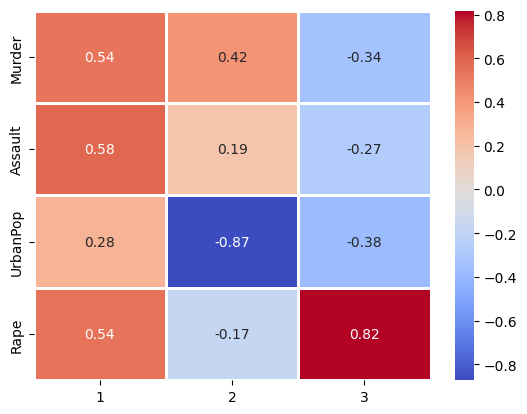

In [1185]:
# correlations between the components and original variables
components = pd.DataFrame(pca_reduced.components_, columns=X.columns, index=range(1, nr_comps+1)).transpose()
ax = sns.heatmap(components, annot=True, cmap='coolwarm',linewidth=1)
plt.show()

We see that the first component is least affected by the urban population and more affected by the crimes, being most affected by assault followed equally by murder and rape. The second component is strongly negatively impacted by the urban population and most positively impacted by murder. The third component is very strongly influenced by rape.

### Clustering

#### Heirachical Clustering

Perform Hierarchical clustering with different linkage methods and distance metrics.

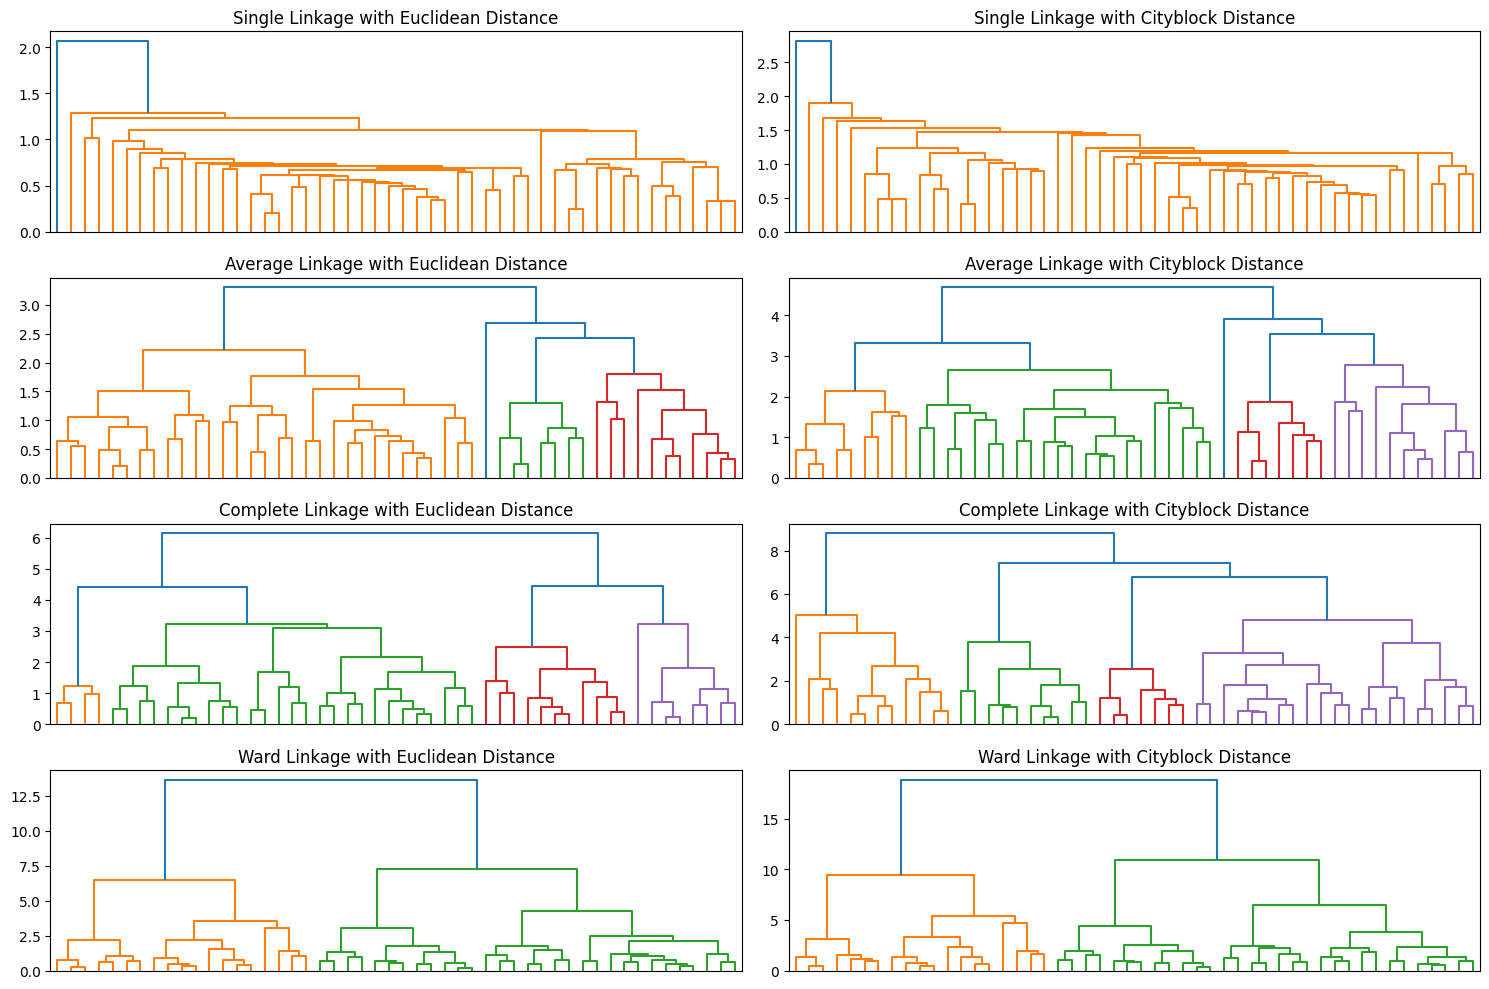

In [1186]:
# Perform Hierarchical clustering with different linkage methods and distance metrics
linkage_methods = ['single', 'average', 'complete', 'ward']
distance_metrics = ['euclidean', 'cityblock']
fig, axes = plt.subplots(4, 2, figsize=(15, 10))

for i, linkage_method in enumerate(linkage_methods):
    for j, distance_metric in enumerate(distance_metrics):
        # Compute the linkage matrix
        Y = pdist(pca_df_reduced, metric=distance_metric)
        Z = linkage(Y, method=linkage_method)

        # Plot the dendrogram
        ax = axes[i, j]
        dendrogram(Z, ax=ax, no_labels=True)
        ax.set_title(f'{linkage_method.capitalize()} Linkage with {distance_metric.capitalize()} Distance')

plt.tight_layout()
plt.show()

Choose linkage method and distance metrics.

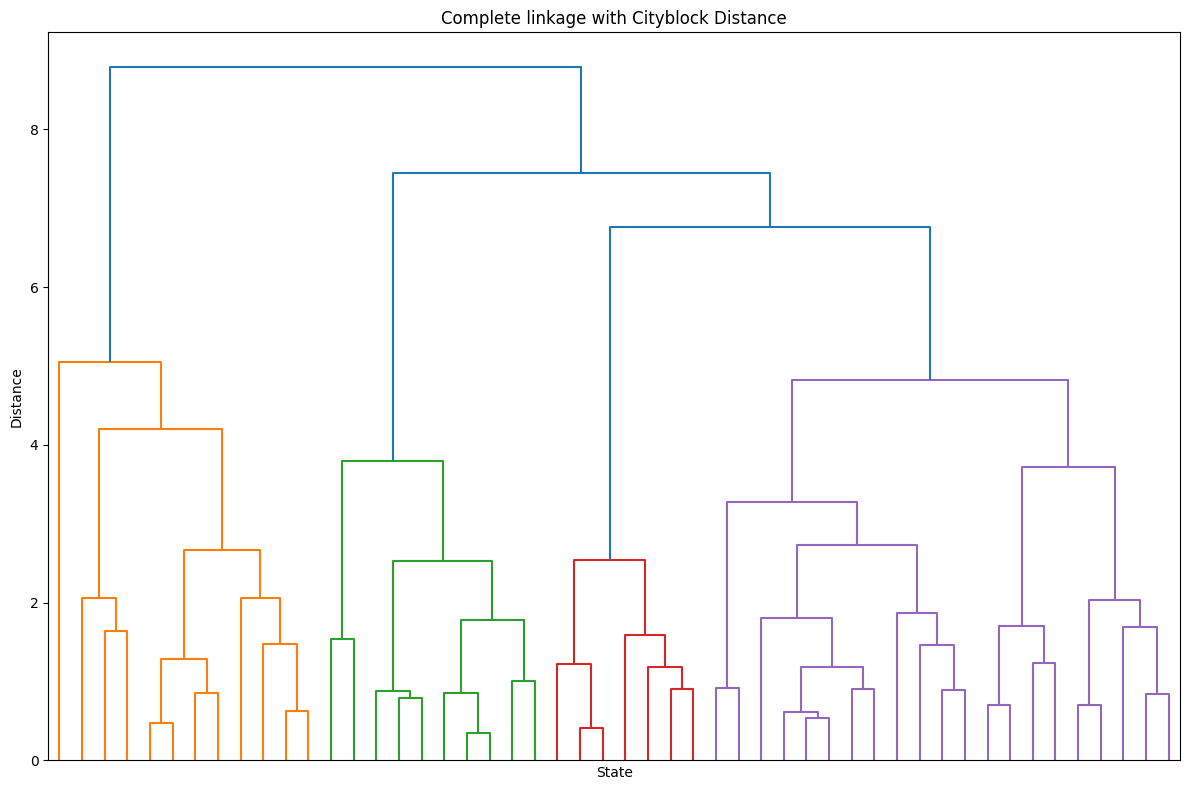

In [1187]:
# Choose linkage method and distance metrics
chosen_linkage = 'complete'
chosen_distance = 'cityblock'


# Compute the linkage matrix with the chosen linkage method and distance metrics
linkage_matrix = linkage(pca_df_reduced, method=chosen_linkage, metric=chosen_distance)

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, no_labels=True)
plt.title(f"{chosen_linkage.capitalize()} linkage with {chosen_distance.capitalize()} Distance")
plt.xlabel('State')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

Plot a scatterplot of the first two principal components with the clusters obtained.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


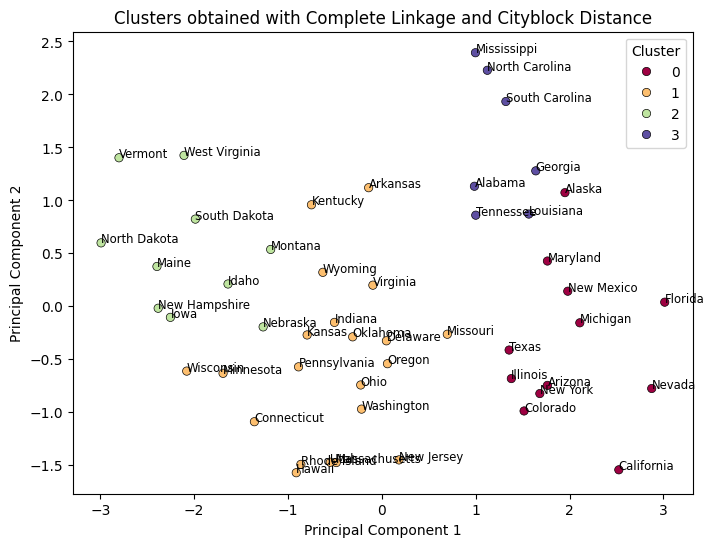

In [1188]:
# Based on the chosen dendrogram choose number of clusters
n_clusters = 4

# Run agglomerative hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=chosen_linkage, affinity=chosen_distance)
labels = clustering.fit_predict(pca_df_reduced)

# Scatter plot of the selected two features with the clusters obtained
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_reduced, x=pca_df_reduced.iloc[:, 0], y=pca_df_reduced.iloc[:, 1], hue=clustering.labels_, palette='Spectral', edgecolor='k')
plt.title(f'Clusters obtained with {chosen_linkage.capitalize()} Linkage and {chosen_distance.capitalize()} Distance')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add labels to each point
for i, point in pca_df_reduced.iterrows():
    plt.text(point[0], point[1], str(i), horizontalalignment='left', size='small', color='black')

plt.legend(title='Cluster')
plt.show()

View the states in each cluster and the cluster sizes.

In [1189]:
# Add the cluster labels to a temporary DataFrame
temp_df = pca_df_reduced.copy()
temp_df['Cluster'] = clustering.labels_

# Group the DataFrame by Cluster and collect states in each group
cluster_groups = temp_df.groupby('Cluster').apply(lambda x: list(x.index)).to_dict()

# Print the states in each cluster
for cluster, states in cluster_groups.items():
    print(f"Cluster {cluster}: {states}")

# Get the size of each cluster group
cluster_sizes = temp_df.groupby('Cluster').size()

print("\nSize of each group:")
print(cluster_sizes)

Cluster 0: ['Alaska', 'Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Nevada', 'New Mexico', 'New York', 'Texas']
Cluster 1: ['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Indiana', 'Kansas', 'Kentucky', 'Massachusetts', 'Minnesota', 'Missouri', 'New Jersey', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Utah', 'Virginia', 'Washington', 'Wisconsin', 'Wyoming']
Cluster 2: ['Idaho', 'Iowa', 'Maine', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'South Dakota', 'Vermont', 'West Virginia']
Cluster 3: ['Alabama', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']

Size of each group:
Cluster
0    12
1    21
2    10
3     7
dtype: int64


#### KMeans Clustering

Plot an elbox curve and Silhouette Score plot to determine number of clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

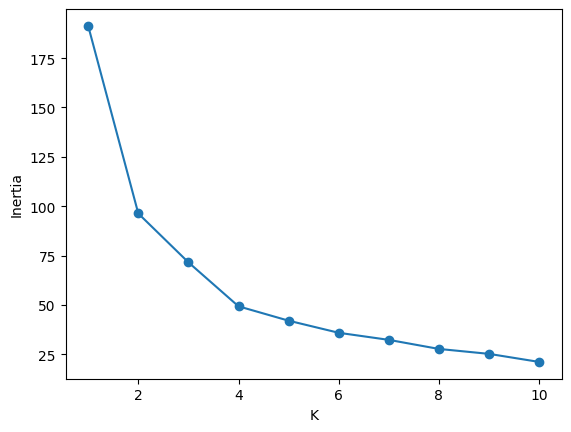

In [1190]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

# Plot elbow curve using scaled dataset
elbow_Kmeans(pca_df_reduced)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

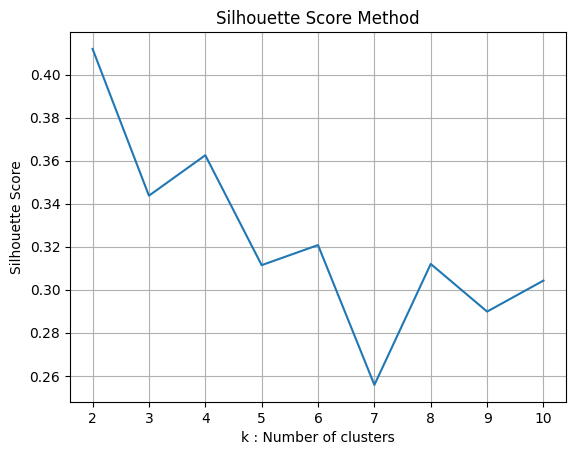

In [1191]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(pca_df_reduced)
    labels = kmeans.labels_
    sil.append(silhouette_score(pca_df_reduced, labels, metric=chosen_distance))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Choose number of clusters and perform KMeans clustering.

In [1192]:
# Chosen K value
k_value = 4

# K-means clustering
kmeans = KMeans(n_clusters=k_value, random_state=rseed, max_iter=500)
kmeans.fit(pca_df_reduced)
pca_df_reduced['KMeans_Cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Get the silhouette score.

In [1193]:
# Calculate silhouette score
silhouette_avg = silhouette_score(pca_df_reduced, pca_df_reduced['KMeans_Cluster'])
print(f"Silhouette Score for K={k_value}: {silhouette_avg}")

Silhouette Score for K=4: 0.5356154435780404


This is a moderate silhouette score.

Plot a scatterplot of the first two principal components with the clusters obtained.

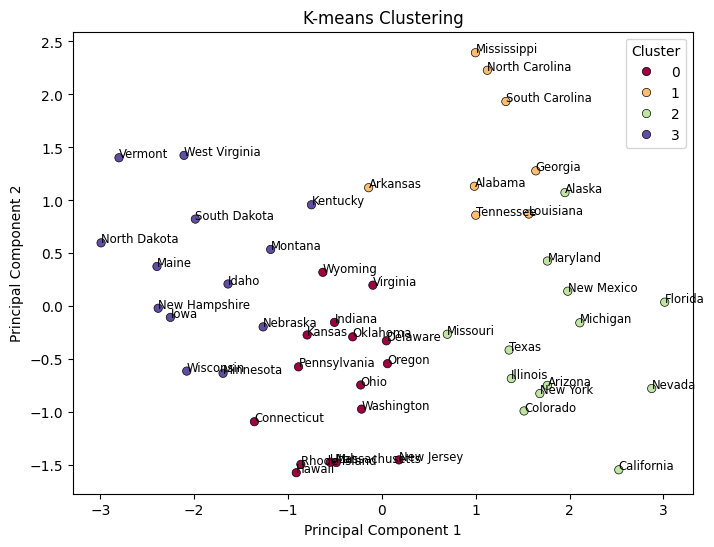

In [1194]:
# Visualize K-means clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_reduced, x=pca_df_reduced.iloc[:,0], y=pca_df_reduced.iloc[:,1], hue='KMeans_Cluster', palette='Spectral', edgecolor='k')
plt.title('K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add labels to each point
for i, point in pca_df_reduced.iterrows():
    plt.text(point[0], point[1], str(i), horizontalalignment='left', size='small', color='black')

plt.legend(title='Cluster')
plt.show()

View the states in each cluster and the cluster sizes.

In [1195]:
# Group the DataFrame by Cluster and collect states in each group
KMeans_groups = pca_df_reduced.groupby('KMeans_Cluster').apply(lambda x: list(x.index)).to_dict()

# Print the states in each cluster
for group, states in KMeans_groups.items():
    print(f"Group {group}: {states}")

# Get the size of each cluster group
group_sizes = pca_df_reduced.groupby('KMeans_Cluster').size()

print("\nSize of each group:")
print(group_sizes)

Group 0: ['Connecticut', 'Delaware', 'Hawaii', 'Indiana', 'Kansas', 'Massachusetts', 'New Jersey', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Utah', 'Virginia', 'Washington', 'Wyoming']
Group 1: ['Alabama', 'Arkansas', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']
Group 2: ['Alaska', 'Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Missouri', 'Nevada', 'New Mexico', 'New York', 'Texas']
Group 3: ['Idaho', 'Iowa', 'Kentucky', 'Maine', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'South Dakota', 'Vermont', 'West Virginia', 'Wisconsin']

Size of each group:
KMeans_Cluster
0    16
1     8
2    13
3    13
dtype: int64


### Discussion

The two clustering methods provided very similar results. The four clusters in each method shall be referred to as follows:
- The top right cluster (cluster 3 in the heirachical clustering and cluster 1 in the KMeans clustering).
- The bottom right cluster (cluster 0 in the heirachical clustering and cluster 2 in the KMeans clustering)
- The middle cluster (cluster 1 in the heirachical clustering and cluster 0 in the KMeans clustering)
- The left cluster (cluster 2 in the heirachical clustering and cluster 3 in the KMeans clustering)


The following is an analysis of the four clusters as they pertain to the two principal components. The interpretations of the principal components can be further confirmed by comparisons with the bar plots of the states versus the different features given in the data distribution visualisations.

1. The top right cluster is strongly impacted by both principal components 1 and 2. This means these states generally experience high crime and have lower urban population percentages. This cluster also contains the smallest number of states. This cluster predominantly consists of states from the Southeastern United States. These states share historical and socio-economic characteristics, including higher poverty rates and lower median incomes compared to the national average. These factors are often correlated with higher crime rates. The lower urban population suggests that crime in these states is not solely an urban issue but also affects less densely populated areas.

2. The bottom right cluster is strongly impacted by principal component 1 and less so by principal component 2. These states also experience higher crime but have higher urban population percentages. This cluster is geographically and economically diverse, including states with large urban centers (e.g., New York, California) and states known for significant tourism (e.g., Florida, Nevada). Urban centers in these states may face challenges related to density which can contribute to higher crime rates.

3. The states in the middle cluster experience a moderate level of crime with generally high urban population percentages. This cluster contains the largest number of states. These states have diverse economic bases, including industrial, technological, and educational hubs. The moderate level of crime with high urban population percentages suggests effective urban management and social policies might be in place.

4. The states in the left cluster are the least impacted by principal component one and more stringly impacted by principal component 2. These states have both low crime and low urban population percentages. This cluster is primarily composed of states with large rural areas and smaller cities. The low crime rates could be attributed to various factors, including strong community networks, lower population density, effective local governance and possibly different socio-economic dynamics compared to more urbanized states.

This cluster-based analysis suggests that while crime and urban population are important factors, they are influenced by a complex interplay of geographic, economic, and social factors unique to each state. Future analyses could benefit from incorporating additional variables, such as education levels, employment rates, and access to healthcare, to gain a more comprehensive understanding of the various dynamics.